In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('./data/Melbourne_housing_FULL.txt')
# print(df)
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


### Dataset columns:

- **suburb** (Suburb): The suburb where the property is located
- **address** (Address): The street address of the property
- **rooms** (Rooms): The number of rooms in the property
- **property_type** (Type): The type of the property (house, townhouse, unit, etc.)
- **price** (Price): The price at which the property was sold
- **sale_type** (Method): The method of sale (auction, private treaty, etc.)
- **seller** (SellerG): The agency or agent who sold the property
- **date** (Date): The date on which the property was sold
- **distance** (Distance): The distance of the property from Melbourne's central business district (CBD) in kilometers
- **postcode** (Postcode): The postcode of the suburb where the property is located
- **bedrooms** (Bedroom2): The number of bedrooms in the property (other than the master bedroom)
- **bathroom** (Bathroom): The number of bathrooms in the property
- **car_spaces** (Car): The number of car spaces in the property
- **land_size** (Landsize): The size of the land on which the property is located in square meters
- **building_area** (BuildingArea): The size of the building on the land in square meters
- **building_year** (YearBuilt): The year in which the building was constructed
- **council** (CouncilArea): The local government area in which the property is located
- **latitude** (Latitude): The latitude coordinate of the property
- **longitude** (Longitude): The longitude coordinate of the property
- **region** (Regionname): The general region in Melbourne (west, north, south-east, etc.)
- **property_count** (Propertycount): The number of properties in the suburb


# **Data Cleaning**

In [3]:
# Check basic info like column types and non-null counts
print('DF basic info')
print(df.info())

# Get some summary statistics for numerical columns
print('Summary stats')
print(df.describe())

# Check for null values
print('Null values')
print(df.isnull().sum())


DF basic info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float

In [4]:
# change column names
df.columns = [
    'suburb', 'address', 'rooms', 'property_type', 'price', 'sale_type', 'seller', 
    'date', 'distance', 'postcode', 'bedrooms', 'bathroom', 'car_spaces', 
    'land_size', 'building_area', 'building_year', 'council', 'latitude', 
    'longitude', 'region', 'property_count'
]

# print(df.columns)

In [5]:
# value types
print(df.dtypes)

suburb             object
address            object
rooms               int64
property_type      object
price             float64
sale_type          object
seller             object
date               object
distance          float64
postcode          float64
bedrooms          float64
bathroom          float64
car_spaces        float64
land_size         float64
building_area     float64
building_year     float64
council            object
latitude          float64
longitude         float64
region             object
property_count    float64
dtype: object


In [6]:
df.head(20)


,suburb,address,rooms,property_type,price,sale_type,seller,date,distance,postcode,...,bathroom,car_spaces,land_size,building_area,building_year,council,latitude,longitude,region,property_count
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0
7,Abbotsford,16 Maugie St,4,h,NaN,SN,Nelson,6/08/2016,2.5,3067.0,...,2.0,2.0,400.0,220.0,2006.0,Yarra City Council,-37.7965,144.9965,Northern Metropolitan,4019.0
8,Abbotsford,53 Turner St,2,h,NaN,S,Biggin,6/08/2016,2.5,3067.0,...,1.0,2.0,201.0,NaN,1900.0,Yarra City Council,-37.7995,144.9974,Northern Metropolitan,4019.0
9,Abbotsford,99 Turner St,2,h,NaN,S,Collins,6/08/2016,2.5,3067.0,...,2.0,1.0,202.0,NaN,1900.0,Yarra City Council,-37.7996,144.9989,Northern Metropolitan,4019.0


In [7]:
# identify columns that should be integer type
numerical_columns = df.select_dtypes(include=['float64']).columns

# columns to integers (remove .0) where appropriate
for col in numerical_columns:
    if df[col].dropna().apply(float.is_integer).all():
        df[col] = df[col].astype('Int64')

print(df.dtypes)

suburb             object
address            object
rooms               int64
property_type      object
price               Int64
sale_type          object
seller             object
date               object
distance          float64
postcode            Int64
bedrooms            Int64
bathroom            Int64
car_spaces          Int64
land_size           Int64
building_area     float64
building_year       Int64
council            object
latitude          float64
longitude         float64
region             object
property_count      Int64
dtype: object


In [8]:
# Get the unique values in each column
unique_values = df.apply(lambda x: x.unique())

# Display the unique values for each column
unique_values_table = pd.DataFrame(unique_values, columns=['Unique Values'])
print(unique_values_table)


                                                    Unique Values
suburb          [Abbotsford, Airport West, Albert Park, Alphin...
address         [68 Studley St, 85 Turner St, 25 Bloomburg St,...
rooms                     [2, 3, 4, 1, 5, 6, 7, 8, 10, 9, 12, 16]
property_type                                           [h, u, t]
price           [<NA>, 1480000, 1035000, 1465000, 850000, 1600...
sale_type                      [SS, S, VB, SP, PI, SN, W, PN, SA]
seller          [Jellis, Biggin, Rounds, Nelson, Collins, Ding...
date            [3/09/2016, 3/12/2016, 4/02/2016, 4/03/2017, 4...
distance        [2.5, 13.5, 3.3, 6.4, 13.8, 11.1, 6.3, 5.9, 11...
postcode        [3067, 3042, 3206, 3078, 3018, 3025, 3143, 303...
bedrooms        [2, 3, 4, 6, <NA>, 1, 5, 7, 0, 8, 9, 30, 20, 1...
bathroom                 [1, 2, <NA>, 3, 7, 4, 0, 5, 6, 12, 8, 9]
car_spaces      [1, 0, 2, <NA>, 6, 5, 4, 3, 8, 7, 11, 26, 9, 1...
land_size       [126, 202, 156, 0, 134, 94, 120, 400, 201, 181...
building_a

In [9]:
# group by 'suburb' and check the uniqueness of 'region' and 'council'
inconsistent_suburbs = df.groupby('suburb').agg(
    region_unique=('region', 'nunique'),
    council_area_unique=('council', 'nunique')  # Fixed the typo here
)

inconsistent_suburbs = inconsistent_suburbs[
    (inconsistent_suburbs['region_unique'] > 1) | (inconsistent_suburbs['council_area_unique'] > 1)
]

if not inconsistent_suburbs.empty:
    print("Inconsistent Suburbs where region or council doesn't match:")
    print(inconsistent_suburbs.index)
else:
    print("All values in 'suburb', 'region', and 'council' match correctly.")


All values in 'suburb', 'region', and 'council' match correctly.


In [24]:
# Fill missing 'region' and 'council' values by using the most frequent value within the same 'suburb'
df['region'] = df.groupby('suburb')['region'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df['council'] = df.groupby('suburb')['council'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

# Verify that the missing values have been filled
print(df[['region', 'council']].isna().sum())


region     0
council    0
dtype: int64


In [22]:
# Count the number of NaN values in each column
empty_values_count = df.isna().sum()

# Filter to show only columns with NaN values (i.e., count > 0)
empty_columns = empty_values_count[empty_values_count > 0]

# Display the columns with empty values and their counts
print("Columns with empty values and their count:")
print(empty_columns)


Columns with empty values and their count:
postcode              1
bedrooms           6441
bathroom           6447
car_spaces         6824
land_size          9265
building_area     16591
building_year     15163
council               3
latitude           6254
longitude          6254
region                3
property_count        3
dtype: int64


# **Assessment Code**

1. Cast the `price` column in the dataset to an integer type and remove any null values in de `price` column. Which of the following statements is true regarding dropping null values?

In [10]:
# cast 'price' column to integer type, remove null values
df.loc[:, 'price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price'])
# print(df)

In [11]:
print(df['price'].unique())

<IntegerArray>
[1480000, 1035000, 1465000,  850000, 1600000,  941000, 1876000, 1636000,
 1000000,  745000,
 ...
  931500, 1019500, 1227500,  717760, 1777500,  991888,  750240, 2685000,
 1671000, 1605500]
Length: 2871, dtype: Int64


A: dropping all null values will lead to a loss of 74% of the data
Correct answer: dropping null values will lead to a loss of 21% of the data

2. What is the most common type of property, and what percentage of the properties does it represent?

In [12]:
print(df['property_type'].value_counts())

property_type
h    18472
u     5909
t     2866
Name: count, dtype: int64


In [13]:
# change property type values
property_types = {
    'h': 'House',
    'u': 'Unit',
    't': 'Townhouse'
}

df['property_type'] = df['property_type'].replace(property_types)

In [14]:
type_counts = df['property_type'].value_counts()

type_percentage = (type_counts / len(df)) * 100

print(type_percentage)

property_type
House        67.794620
Unit         21.686791
Townhouse    10.518589
Name: count, dtype: float64


A: The most common type of property is houses, and they represent 67% of the properties.

3. Create a graph to show the frequency of each property type n descending order. Which graph technique is the most suitable and straightforward approach for this task?

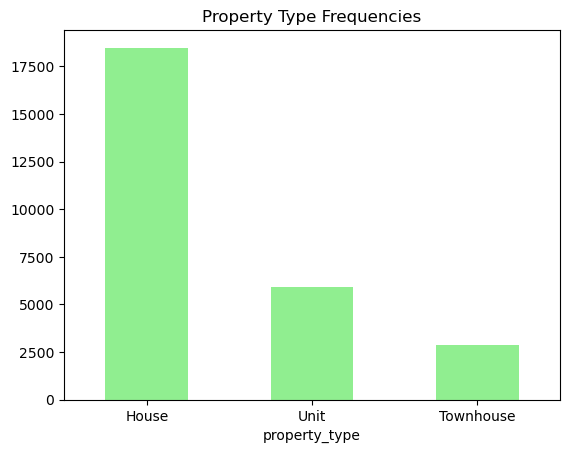

In [15]:
type_counts.sort_values(ascending=False).plot(kind='bar', color='lightgreen')

plt.title('Property Type Frequencies')
plt.xticks(rotation=0)
plt.show()

Answer: barplot
Correct answer: Countplot

4. How does the number of rooms impact the median property price? Represent this relationship using a bar chart.
   `Rooms`, `Price`

In [16]:
# group by 'rooms' and calculate the median 'price' for each group
median_price_per_room = df.groupby('rooms')['price'].median()
display(median_price_per_room)

rooms
1      390000.0
2      678000.0
3      900000.0
4     1205250.0
5     1550000.0
6     1660000.0
7     1350000.0
8     1535883.0
9     1380000.0
10    2115000.0
12    2705000.0
16    5000000.0
Name: price, dtype: Float64

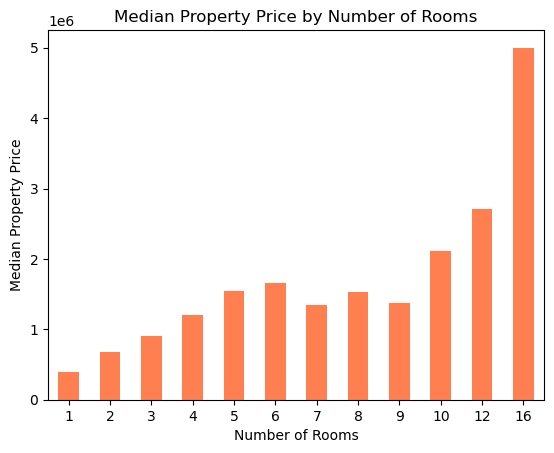

In [17]:
median_price_per_room.plot(kind='bar', color='coral')
plt.title('Median Property Price by Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Median Property Price')
plt.xticks(rotation=0)
plt.show()

A: The median property price generally increases with the number of rooms, but there are some exceptions where the price decreases or remains the same.

5. Since the relationship between property price and number of rooms may not be linear, it is appropriate to use a non-parametric correlation coefficient such as Spearman's to determine the strength of the relationship. Calculate the Spearman correlation coefficient to analyze the relationship between price and number of rooms.

In [18]:
# calculate Spearman's rank correlation coefficient
spearman_corr, p_value = spearmanr(df['rooms'], df['price'])

print(f'Correlation coefficient: {spearman_corr}')
print(f'P_value: {p_value}')

Correlation coefficient: 0.5042971590926004
P_value: 0.0


Interpretation:
Spearman's Rank Correlation Coefficient (0.5043):
The value of 0.5043 indicates a moderate positive monotonic relationship between the number of rooms and the property price. This means that as the number of rooms increases, the property price tends to increase as well, but not in a perfectly linear manner. There is some level of positive correlation, though it's not extremely strong.
P-value (0.0):
The p-value of 0.0 is very small, which suggests that the correlation is statistically significant. In other words, there is a very low probability that the observed correlation is due to random chance. You can confidently conclude that there is a meaningful relationship between the number of rooms and the property price in your data.
Conclusion:
The moderate positive Spearman correlation (0.5043) suggests that as the number of rooms increases, property prices tend to increase, but not perfectly. The strong statistical significance (p-value = 0.0) indicates that this relationship is unlikely to be due to chance.

A: The correlation between property price and number of rooms is moderate.

6. Is there a relationship between the distance from the Central Business District (CBD) and the property price?
Use a scatter plot to visualize the relationship and calculate a correlation coefficient to determine the strength and direction of the correlation.

In [19]:
# fill empty values with mean
df['distance'] = df['distance'].fillna(df['distance'].mean())

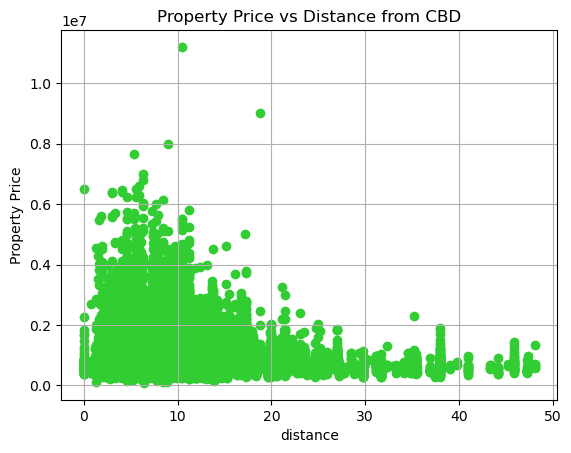

Pearson correlation coefficient: -0.21138256559555657
P-value: 8.33356651089412e-273


In [20]:
plt.scatter(df['distance'], df['price'], color='limegreen')
plt.title('Property Price vs Distance from CBD')
plt.xlabel('distance')
plt.ylabel('Property Price')
plt.grid(True)
plt.show()

# Pearson correlation coefficient
pearson_corr, p_value = pearsonr(df['distance'], df['price'])

print(f'Pearson correlation coefficient: {pearson_corr}')
print(f'P-value: {p_value}')

A: There is a weak negative correlation between the distance from CBD and the property price.

7. Is there a relationship between the property size and the property price?

In [21]:
# fill empty values with mean
df['land_size'] = df['land_size'].fillna(df['land_size'].mean())

TypeError: Invalid value '593.4889333778223' for dtype Int64

In [ ]:
# Scatter plot to visualize the relationship
plt.scatter(df['land_size'], df['price'], color='hotpink')
plt.title('Property Price vs Property Size')
plt.xlabel('Size (land and building)')
plt.ylabel('price')
plt.grid(True)
plt.show()

# Calculate Pearson correlation coefficient
pearson_corr, p_value = pearsonr(df['land_size'], df['price'])

# Print the correlation coefficient and p-value
print(f'Pearson correlation coefficient: {pearson_corr}')
print(f'P-value: {p_value}')

A: There is a weak positive linear relationship between property size and property price.
Correct answer: There is a weak positive correlation between the two variables, but the relationship might not be linear.

8. When looking visually at the relationship between land size and property price, a scatter plot might not be the most informative way to visualize this relationship.
We can use a **quantile-based discretization function** to categorize the Landsize variable and create a bar plot.
When using **q=7**, how does the relationship between land size and median property price change compared to using a lower quantile value?

When using a quantile-based discretization function to categorize the Landsize variable into quantiles (such as q=7), you're dividing the land size into 7 equal-sized groups, each containing approximately the same number of data points. This approach transforms a continuous variable (land size) into a categorical one, where each group corresponds to a range of land sizes. By comparing this method to a lower quantile value (such as q=4), you can observe how the relationship between land size and median property price changes.

Summary:
Using q=7 provides a higher level of detail, allowing you to more clearly observe subtle differences in property price across land sizes.
Using a lower quantile value (e.g., q=4) smooths out these differences, resulting in a less granular view of the relationship, which could mask finer distinctions in property prices as they relate to land size.

A: The relationship between land size and property price becomes more pronounced when using q=7 compared to a lower quantile value.
Correct answer: The frequency of properties with a larger land size having a lower price than properties with a smaller land size increases when using q=7, compared to a lower quantile value.

Explanation:
Using q=7 means dividing the land size into 7 quantiles, which creates more granular groups, allowing for finer distinctions in the relationship between land size and property price. This increases the resolution of the data, helping to reveal more subtle trends and variations.
In contrast, using a lower quantile value (e.g., q=4) results in fewer groups, which may smooth out the relationship and make it harder to see more pronounced differences.
Thus, when using q=7, the relationship between land size and property price is more pronounced due to the finer categorization, making it easier to observe variations across different land size ranges.

9. Does the dataset contain any properties that are priced significantly above or below the average? To investigate, create a box plot to detect potential outliers, and use Tukey's method with a 1.5 threshold to create a new dataframe without these outliers. 
What percentage of properties are identified as outliers using Tukey's method?

In [ ]:
# box plot to visually identify potential outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df['price'])
plt.title('Property Prices')
plt.ylabel('price')
plt.show()

In [ ]:
# Tukey's method

# thresholds
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Tukey's method to detect outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')
# print(f'Outliers: {outliers}')

In [ ]:
# new df without outliers
outlier_free_df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# percentage of outliers
percentage_outliers = (len(outliers) / len(df)) * 100

print(f'Percentage of outliers: {percentage_outliers:.2f}%')

A: 4.69%

10. How is the property price distribution? Create a QQ (Quantile-Quantile) Plot to compare the distribution of property prices to a normal distribution visually, and calculate the skew and curtosis to get a better understanding of the shape of the distribution analytically.

In [ ]:
# create QQ plot to compare distribution
plt.figure(figsize=(8, 6))
stats.probplot(df['price'], dist='norm', plot=plt)
plt.title('QQ Plot: Property Prices vs Normal Distribution')
plt.show()

In [ ]:
# calculate skewness and kurtosis
skewness = df['price'].skew()
kurtosis = df['price'].kurtosis()

print(f'Skewness: {skewness:.2f}')
print(f'Kurtosis: {kurtosis:.2f}')

A: The property price distribution is positively skewed.

Explanation:
Skewness of 2.59 indicates a positive skew, meaning the distribution is right-skewed (with a long tail on the right side), where most property prices are lower, but a few high-priced properties create a longer tail on the right.

The kurtosis value of 13.10 confirms the presence of heavy tails (more extreme high values than normal), which further supports the idea of outliers in the higher price range, a characteristic of a positively skewed distribution.

11. What is the outcome of performing a normality test, such as the *Kolmogorov-Smirnov Test*, on the distribution of property prices? Specifically, what possible conclusions can be drawn from the test results regarding the similarity of the distribution to a normal distribution?

Kolmogorov-Smirnov Test:
Null Hypothesis (H₀): The data follows a normal distribution.
Alternative Hypothesis (H₁): The data does not follow a normal distribution.

In [ ]:
# standardize prices (mean 0, std 1)
standardized_prices = (df['price'] - df['price'].mean()) / df['price'].std()
# print(standardized_prices)

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(standardized_prices, 'norm')

print(f'KS statistic: {ks_statistic:.4f}')
print(f'p-value: {p_value:.4f}')

# interpretation based on p-value
if p_value < 0.05:
    print('The null hypothesis is rejected: The distribution of property prices is significantly different from a normal distribution.')
else:
    print('The null hypothesis cannot be rejected: The distribution of property prices is not significantly different from a normal distribution.')

A: The test results indicate that the distribution of property prices in the Melbourne housing market dataset is significantly different from a normal distribution.

12. How do property prices differ between different property types? Create a box plot to show the distribution of property prices for each property type.

In [ ]:
# a box plot to show the distribution of property prices for each property type
plt.figure(figsize=(12, 8))
sns.boxplot(x='property_type', y='price', data=df)

plt.title('Property Price Distribution by Property Type', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Property Price', fontsize=14)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

A: Houses have higher property prices than units and townhouses.

13. What is the region with the highest median price? Conversely, which region has the lowest median price?

In [ ]:
import pandas as pd

# Assuming you already have the DataFrame df with 'price' and 'region' columns

# Group by 'region' and calculate the median of 'price'
region_medians = df.groupby('region')['price'].median()

# Find the region with the highest median price
highest_median_region = region_medians.idxmax()
highest_median_price = region_medians.max()

# Find the region with the lowest median price
lowest_median_region = region_medians.idxmin()
lowest_median_price = region_medians.min()

# Print the results
print(f'Region with the highest median price: {highest_median_region} (Median Price: {highest_median_price})')
print(f'Region with the lowest median price: {lowest_median_region} (Median Price: {lowest_median_price})')


A: Most expensive: Southern Metropolitan, Cheapest: Western Victoria

14. Is there a statistically significant association between the region and the price of properties? Use the *chi square test* to assess the independence between region and price, and *Cramer's V coefficient* to quantify the strength of the association between these two features.

        It's worth noting that in order to perform this analysis, both features need to be categorical. Divide the price variable into five distinc ranges.
        Use Cohen (1988) interpretation on Cramer's V, which depends on the degrees of freedom.

In [ ]:
# Step 1: Categorize the 'price' column into five distinct ranges
price_bins = [0, 300000, 500000, 700000, 900000, np.inf]
price_labels = ['0-300k', '300k-500k', '500k-700k', '700k-900k', '900k+']
df['price_category'] = pd.cut(df['price'], bins=price_bins, labels=price_labels)

# Step 2: Create a contingency table of 'price_category' vs 'region'
contingency_table = pd.crosstab(df['price_category'], df['region'])

# Step 3: Perform the Chi-Square Test of Independence
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Step 4: Calculate Cramer's V coefficient
n = contingency_table.sum().sum()  # Total number of observations
min_dim = min(contingency_table.shape) - 1  # Minimum of (rows-1, columns-1)
cramers_v = np.sqrt(chi2_stat / (n * min_dim))

# Step 5: Interpret the results
print(f"Chi-Square Test Statistic: {chi2_stat:.4f}")
print(f"p-value: {p_val:.4f}")
print(f"Cramer's V: {cramers_v:.4f}")

# Chi-Square Test Interpretation
if p_val < 0.05:
    print("There is a statistically significant association between region and price (reject H0).")
else:
    print("There is no statistically significant association between region and price (fail to reject H0).")

# Cramer's V Interpretation based on Cohen (1988)
if cramers_v < 0.1:
    print("The association between region and price is weak.")
elif cramers_v < 0.3:
    print("The association between region and price is moderate.")
else:
    print("The association between region and price is strong.")

# Optionally, visualize the contingency table
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d")
plt.title("Contingency Table Heatmap")
plt.show()

A: Yes, there is a significant relationship between the region and the price of properties, and the relationship is medium.

15. How much was the percentage increase or decrease in *median price* of properties sold between the earliest year and the latest year (`Date` column)?

In [ ]:
# Step 1: Ensure 'date' is in datetime format and extract the year
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime, handle errors if any
df['year'] = df['date'].dt.year  # Extract year from the Date column

# Step 2: Group by Year and calculate the median price for each year
median_prices_by_year = df.groupby('year')['price'].median()

# Step 3: Get the earliest and latest year
# earliest_year = median_prices_by_year.idxmin()  # The year with the minimum median price
# latest_year = median_prices_by_year.idxmax()   # The year with the maximum median price
earliest_year = 2016
latest_year = 2018
# Step 4: Calculate the median price in the earliest and latest year
median_price_earliest = median_prices_by_year[earliest_year]
median_price_latest = median_prices_by_year[latest_year]

# Step 5: Calculate the percentage change in median price
percentage_change = ((median_price_latest - median_price_earliest) / median_price_earliest) * 100

# Print results
print(f"Median price in {earliest_year}: {median_price_earliest}")
print(f"Median price in {latest_year}: {median_price_latest}")
print(f"Percentage change in median price from {earliest_year} to {latest_year}: {percentage_change:.2f}%")

In [ ]:
print(df['year'].unique())

A: -10.37%
Correct answer: -5.48%

16. Is there a specific month during which more houses are sold?

In [ ]:
# convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Ensure Date is in datetime format

# extract the month from the 'date' column
df['month'] = df['date'].dt.month

# count the number of properties sold per month
sales_per_month = df['month'].value_counts().sort_index()  # Count occurrences per month, sorted by month

# Step 4: Identify the month with the most sales
most_sales_month = sales_per_month.idxmax()
most_sales_count = sales_per_month.max()

# Step 5: Print the results
print(f"The month with the most houses sold is month {most_sales_month} with {most_sales_count} sales.")


A: March.
Correct answer: November.